




<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

# Gallagher - Assignment 2


## Data Preperation

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

### Imports

In [ ]:
# Data analysis
import numpy as np
import pandas as pd
from packaging import version
from datetime import datetime as dt

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Visulization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


### Mount Google Drive to Colab Environment

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

### EDA Functions

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

In [ ]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

### Research Assignment Reporting Functions

In [ ]:
# Accuracy and loss Line plots visual
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [ ]:
# Shows Accuracy & Root Mean Square Error scores
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [ ]:
# Confusion Matrix visual
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

### EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test
* Imported 50000 labels for training and 10000 labels for test

In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review Labels

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Subset of Examples

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

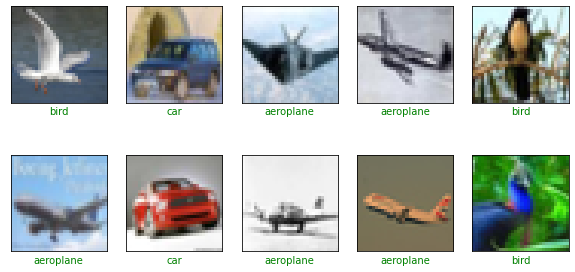

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

### Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

### Create Validation Data Set

In [ ]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

### Confirm Datasets {Train, Validation, Test}

In [ ]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255


1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# Create the Models

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


## Experiment 1: DNN with 2 layers (no regularization)

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [ ]:
model1 = models.Sequential()
model1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
# 1st layer
model1.add(layers.Dense(name='layer1',units = 256, activation = tf.nn.relu))
# 2nd layer
model1.add(layers.Dense(name='layer2',units = 512, activation = tf.nn.relu))
# output layer ## Without Regularization
model1.add(layers.Dense(name='OuputLayer',units = 10, activation = tf.nn.softmax)) # 10 input layers for 10 classes

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 layer1 (Dense)              (None, 256)               786688    
                                                                 
 layer2 (Dense)              (None, 512)               131584    
                                                                 
 OuputLayer (Dense)          (None, 10)                5130      
                                                                 
Total params: 923,402
Trainable params: 923,402
Non-trainable params: 0
_________________________________________________________________


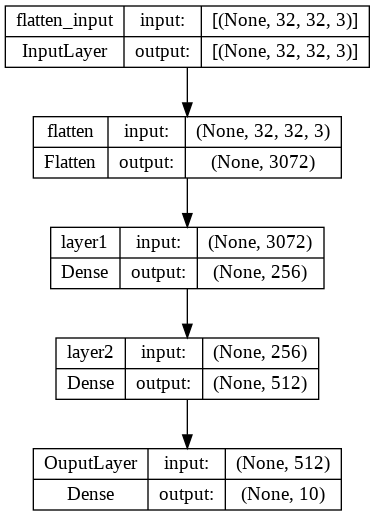

In [ ]:
keras.utils.plot_model(model1, "CIFAR10.png", show_shapes=True)

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start_time = dt.now()
history = model1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model1.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model1 fit time: {end_time-start_time}')

Epoch 1/200
88/88 [==============================] - 3s 10ms/step - loss: 2.0154 - accuracy: 0.2759 - val_loss: 1.8332 - val_accuracy: 0.3418
Epoch 2/200
88/88 [==============================] - 1s 7ms/step - loss: 1.7633 - accuracy: 0.3721 - val_loss: 1.7329 - val_accuracy: 0.3818
Epoch 3/200
88/88 [==============================] - 1s 7ms/step - loss: 1.6694 - accuracy: 0.4052 - val_loss: 1.6981 - val_accuracy: 0.3926
Epoch 4/200
88/88 [==============================] - 1s 7ms/step - loss: 1.6070 - accuracy: 0.4292 - val_loss: 1.6505 - val_accuracy: 0.4030
Epoch 5/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5669 - accuracy: 0.4442 - val_loss: 1.5952 - val_accuracy: 0.4250
Epoch 6/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5142 - accuracy: 0.4630 - val_loss: 1.5596 - val_accuracy: 0.4442
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4900 - accuracy: 0.4696 - val_loss: 1.5262 - val_accuracy: 0.4564
Epoch 8/200


### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model1 = tf.keras.models.load_model("DNN_model1.h5")
print(f"Test acc: {model1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.3837 - accuracy: 0.5063
Test acc: 0.506


### Predictions

In [ ]:
preds = model1.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
13  1.315     0.535     1.451         0.485
14  1.313     0.536     1.428         0.498
15  1.287     0.543     1.439         0.484
16  1.274     0.549     1.459         0.480
17  1.252     0.557     1.420         0.496

### Plot Training Metrics (Loss and Accuracy)

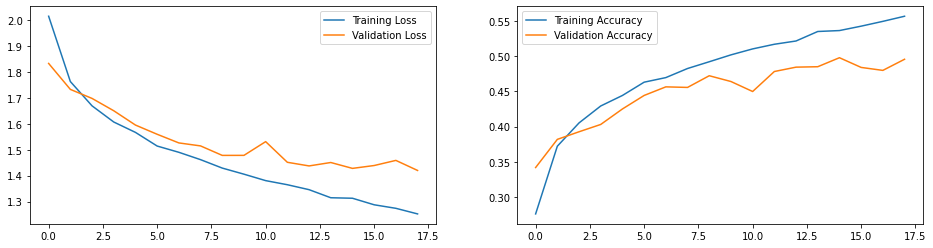

In [ ]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model1.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      1000
           1       0.71      0.51      0.59      1000
           2       0.38      0.39      0.39      1000
           3       0.33      0.39      0.36      1000
           4       0.51      0.36      0.43      1000
           5       0.46      0.35      0.40      1000
           6       0.48      0.67      0.56      1000
           7       0.56      0.58      0.57      1000
           8       0.56      0.73      0.64      1000
           9       0.53      0.65      0.58      1000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.50     10000
weighted avg       0.52      0.51      0.50     10000

Accuracy Score: 0.5063
Root Mean Square Error: 3.080146100430952


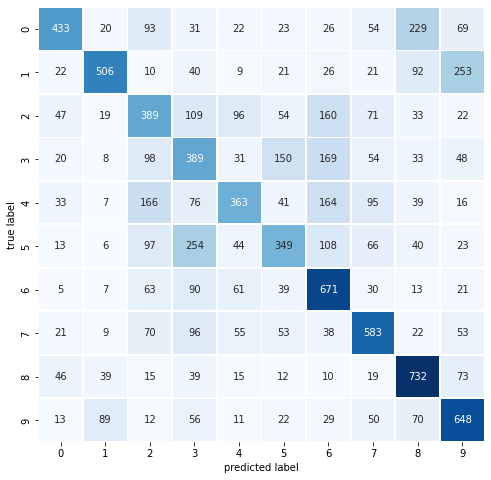

In [ ]:
plot_confusion_matrix(y_test,pred1)

### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model1 = tf.keras.models.load_model('DNN_model1.h5')

In [ ]:
preds = model1.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


In [ ]:
preds.shape

(10000, 10)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

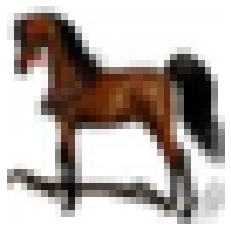

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model1.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model1.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 115ms/step


4

In [ ]:
layer_names = []
for layer in model1.layers:
    layer_names.append(layer.name)

layer_names

['flatten', 'layer1', 'layer2', 'OuputLayer']

In [ ]:
# This cell often crashes

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model1.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model1.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 2ms/step




```
# This is formatted as code
```

### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.199646
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.841843
[t-SNE] KL divergence after 300 iterations: 2.448337


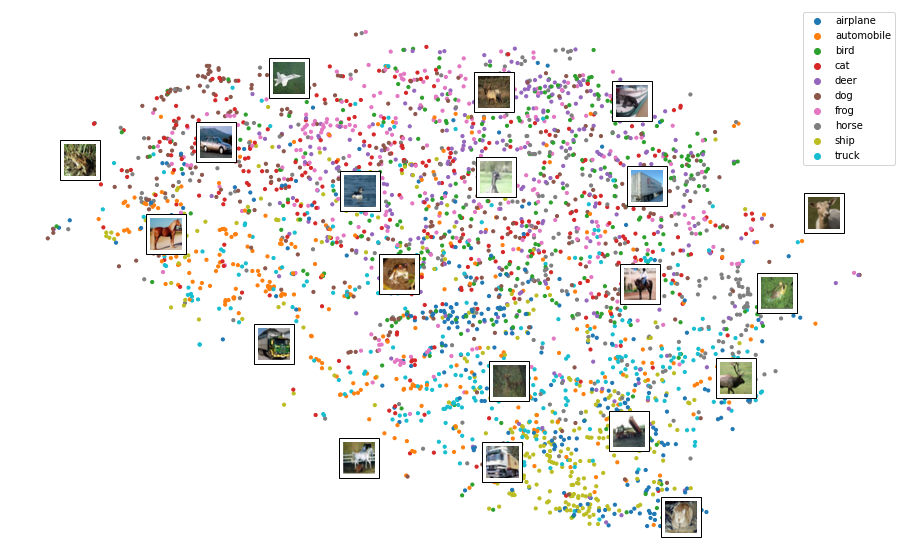

In [ ]:
# Plotting T-SNE
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 2: DNN with 3 layers (no regularization)

In [ ]:
model2 = models.Sequential()
model2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
# 1st layer
model2.add(layers.Dense(name='layer1',units = 256, activation = tf.nn.relu))
# 2nd layer
model2.add(layers.Dense(name='layer2',units = 512, activation = tf.nn.relu))
# 3rd layer
model2.add(layers.Dense(name='layer3',units = 512, activation = tf.nn.relu))
# output layer ## Without Regularization
model2.add(layers.Dense(name='OuputLayer',units = 10, activation = tf.nn.softmax)) # 10 input layers for 10 classes

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 layer1 (Dense)              (None, 256)               786688    
                                                                 
 layer2 (Dense)              (None, 512)               131584    
                                                                 
 layer3 (Dense)              (None, 512)               262656    
                                                                 
 OuputLayer (Dense)          (None, 10)                5130      
                                                                 
Total params: 1,186,058
Trainable params: 1,186,058
Non-trainable params: 0
_________________________________________________________________


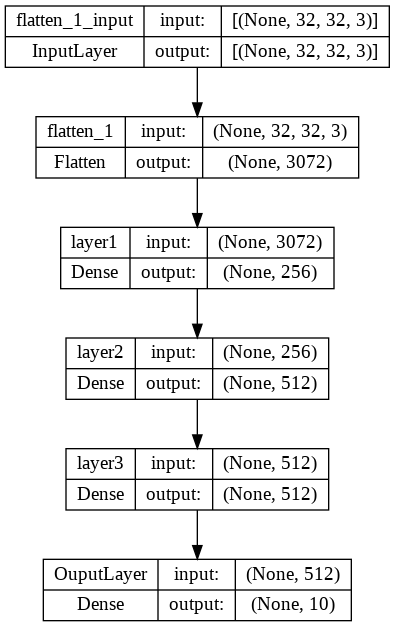

In [ ]:
keras.utils.plot_model(model2, "CIFAR10.png", show_shapes=True)

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start_time = dt.now()
history = model2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model2.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model2 fit time: {end_time-start_time}')

Epoch 1/200
88/88 [==============================] - 1s 10ms/step - loss: 1.9476 - accuracy: 0.2858 - val_loss: 1.8195 - val_accuracy: 0.3472
Epoch 2/200
88/88 [==============================] - 1s 7ms/step - loss: 1.7017 - accuracy: 0.3916 - val_loss: 1.6605 - val_accuracy: 0.3954
Epoch 3/200
88/88 [==============================] - 1s 7ms/step - loss: 1.6097 - accuracy: 0.4244 - val_loss: 1.5891 - val_accuracy: 0.4164
Epoch 4/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5445 - accuracy: 0.4476 - val_loss: 1.5570 - val_accuracy: 0.4478
Epoch 5/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4935 - accuracy: 0.4672 - val_loss: 1.5686 - val_accuracy: 0.4264
Epoch 6/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4554 - accuracy: 0.4795 - val_loss: 1.5153 - val_accuracy: 0.4512
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4203 - accuracy: 0.4928 - val_loss: 1.4875 - val_accuracy: 0.4634
Epoch 8/200


### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model2 = tf.keras.models.load_model("DNN_model2.h5")
print(f"Test acc: {model2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.3857 - accuracy: 0.5077
Test acc: 0.508


### Predictions

In [ ]:
preds = model2.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
9   1.327     0.526     1.461         0.471
10  1.305     0.536     1.418         0.496
11  1.275     0.547     1.430         0.486
12  1.255     0.553     1.423         0.489
13  1.216     0.565     1.430         0.491

### Plot Training Metrics (Loss and Accuracy)

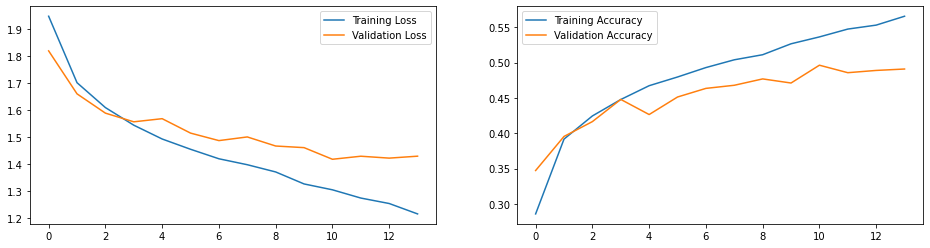

In [ ]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model2.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.53      0.55      1000
           1       0.62      0.62      0.62      1000
           2       0.45      0.33      0.38      1000
           3       0.36      0.36      0.36      1000
           4       0.47      0.40      0.43      1000
           5       0.42      0.37      0.39      1000
           6       0.52      0.60      0.56      1000
           7       0.53      0.61      0.56      1000
           8       0.56      0.70      0.62      1000
           9       0.53      0.56      0.54      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000

Accuracy Score: 0.5077
Root Mean Square Error: 3.090631003533097


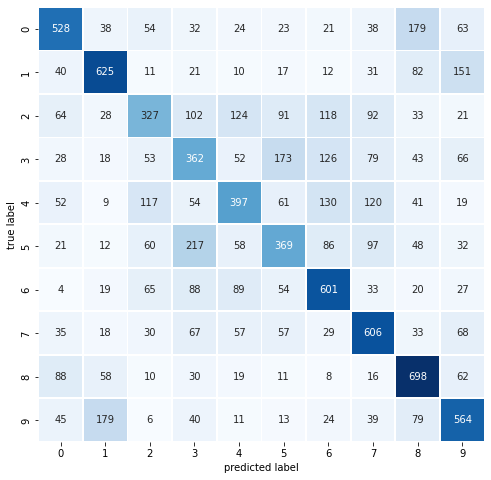

In [ ]:
plot_confusion_matrix(y_test,pred1)

### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model2 = tf.keras.models.load_model('DNN_model2.h5')

In [ ]:
preds = model2.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


In [ ]:
preds.shape

(10000, 10)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

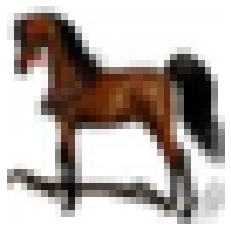

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model2.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 57ms/step


5

In [ ]:
layer_names = []
for layer in model2.layers:
    layer_names.append(layer.name)

layer_names

['flatten_1', 'layer1', 'layer2', 'layer3', 'OuputLayer']

In [ ]:
# Crashes

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model2.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 3ms/step




```
# This is formatted as code
```

### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.678s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 1.925636
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.389519
[t-SNE] KL divergence after 300 iterations: 2.360343


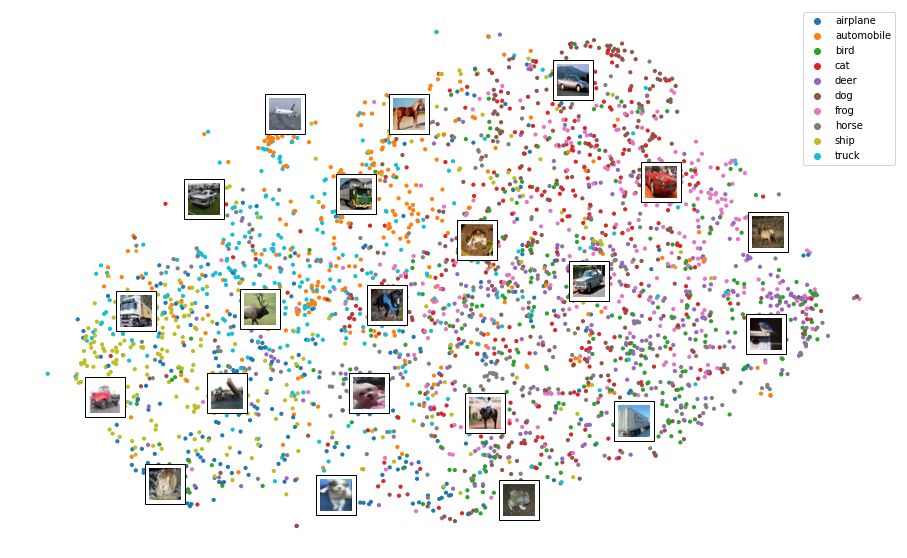

In [ ]:
# Plotting T-SNE
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)


We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [ ]:
model3 = Sequential([
  # layer 1
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  # layer 2
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  # Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # No regularization for this experiment
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

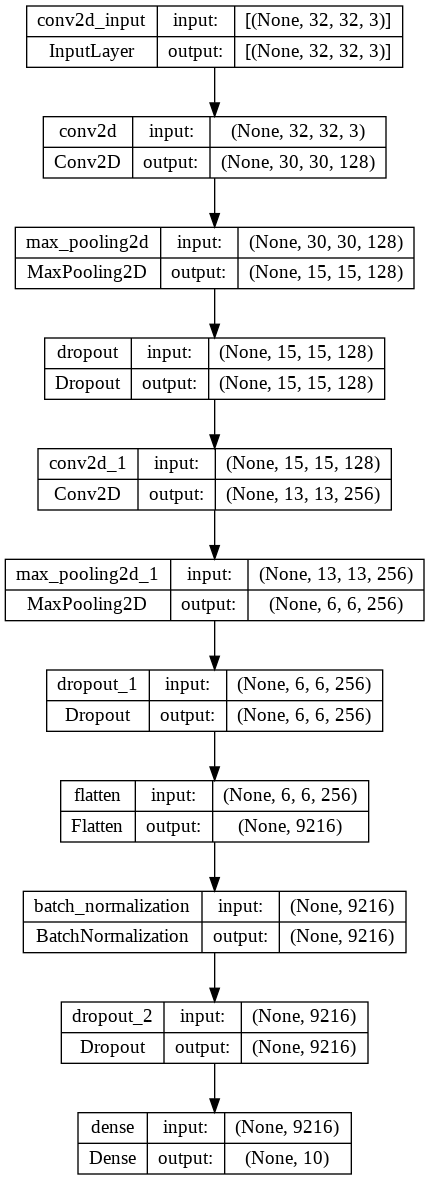

In [ ]:
keras.utils.plot_model(model3, "CIFAR10.png", show_shapes=True)

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start_time = dt.now()
history = model3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model3.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model3 fit time: {end_time-start_time}')

Epoch 1/200
704/704 [==============================] - 15s 11ms/step - loss: 1.5437 - accuracy: 0.4540 - val_loss: 1.3729 - val_accuracy: 0.5116
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 1.2497 - accuracy: 0.5607 - val_loss: 1.2786 - val_accuracy: 0.5286
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.1780 - accuracy: 0.5897 - val_loss: 1.1024 - val_accuracy: 0.6092
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.1262 - accuracy: 0.6096 - val_loss: 1.1640 - val_accuracy: 0.5902
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.0856 - accuracy: 0.6229 - val_loss: 1.4274 - val_accuracy: 0.5208
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.0615 - accuracy: 0.6332 - val_loss: 1.0419 - val_accuracy: 0.6400
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.0332 - accuracy: 0.6398 - val_loss: 1.1627 - val_accuracy

### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model3 = tf.keras.models.load_model("CNN_model3.h5")
print(f"Test acc: {model3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8910 - accuracy: 0.6989
Test acc: 0.699


### Predictions

In [ ]:
preds = model3.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
12  0.966     0.667     0.985         0.643
13  0.962     0.669     0.872         0.692
14  0.948     0.674     0.948         0.668
15  0.931     0.679     0.928         0.664
16  0.926     0.683     1.031         0.646

### Plot Training Metrics (Loss and Accuracy)

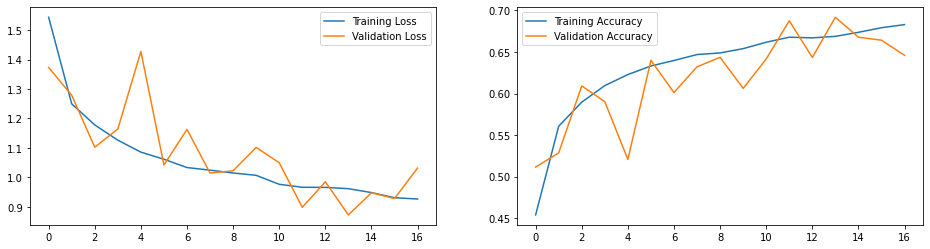

In [ ]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model3.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1000
           1       0.88      0.82      0.85      1000
           2       0.60      0.55      0.58      1000
           3       0.51      0.47      0.49      1000
           4       0.61      0.65      0.63      1000
           5       0.54      0.73      0.62      1000
           6       0.68      0.84      0.75      1000
           7       0.80      0.69      0.74      1000
           8       0.82      0.81      0.81      1000
           9       0.83      0.77      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

Accuracy Score: 0.6989
Root Mean Square Error: 2.188880992653552


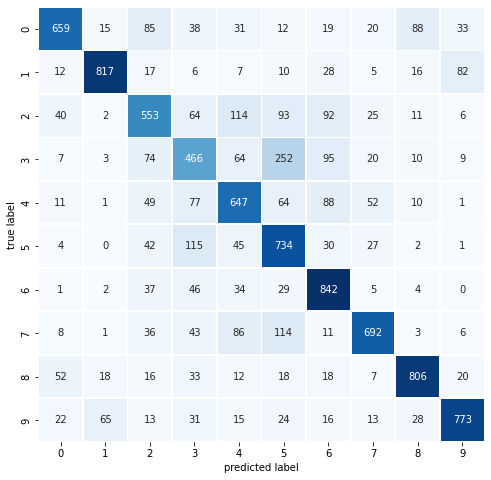

In [ ]:
plot_confusion_matrix(y_test,pred1)

### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model3 = tf.keras.models.load_model('CNN_model3.h5')

In [ ]:
preds = model3.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


In [ ]:
preds.shape

(10000, 10)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

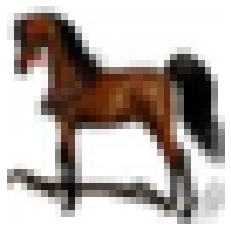

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model3.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model3.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 96ms/step


8

In [ ]:
layer_names = []
for layer in model3.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'flatten',
 'batch_normalization',
 'dropout_2',
 'dense']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


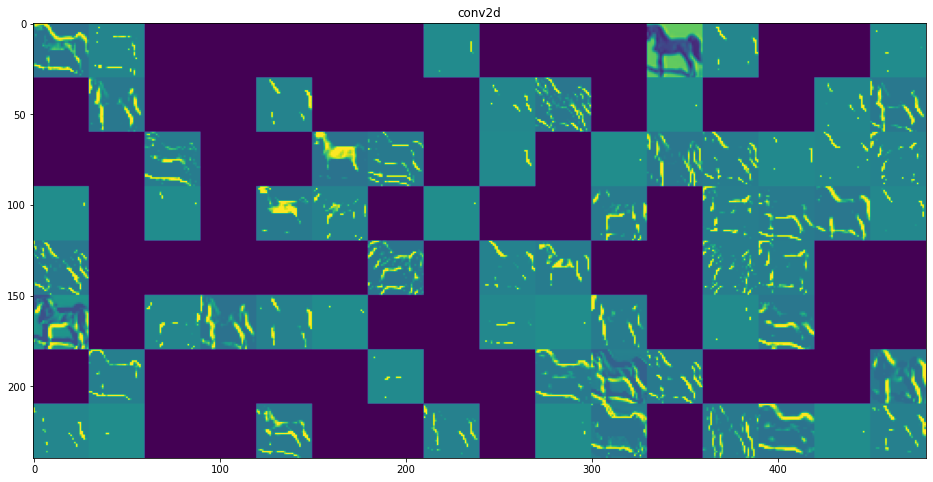

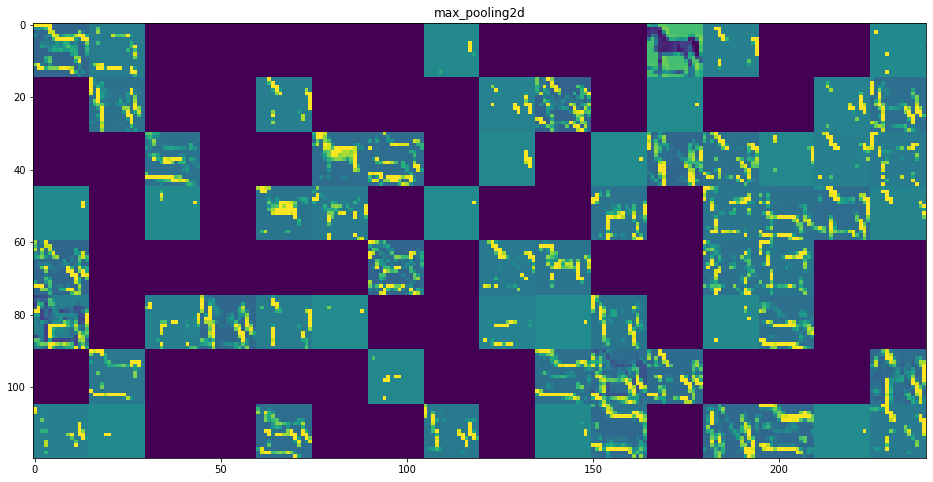

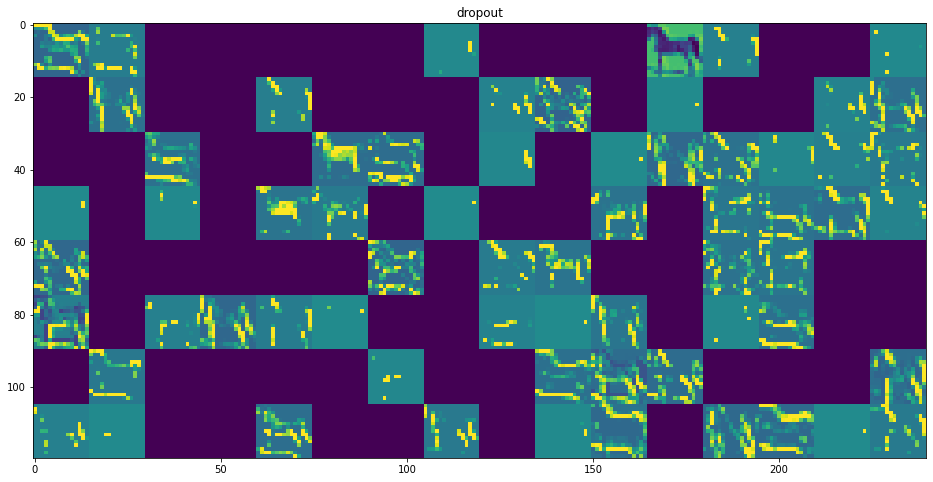

In [ ]:
# crahses

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model3.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model3.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model3.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 3ms/step




```
# This is formatted as code
```

### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.023s...
[t-SNE] Computed neighbors for 3250 samples in 4.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.288584
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.335052
[t-SNE] KL divergence after 300 iterations: 3.334470


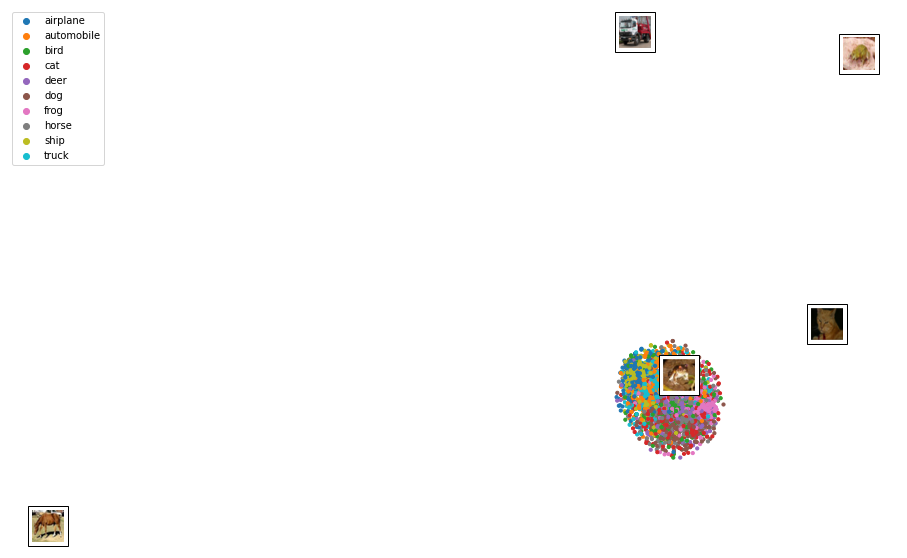

In [ ]:
# Plotting T-SNE
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()


## Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)


We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [ ]:
model4 = Sequential([
  # layer 1
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  # layer 2
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  # layer 3
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  # Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Not using regularization
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 256)        

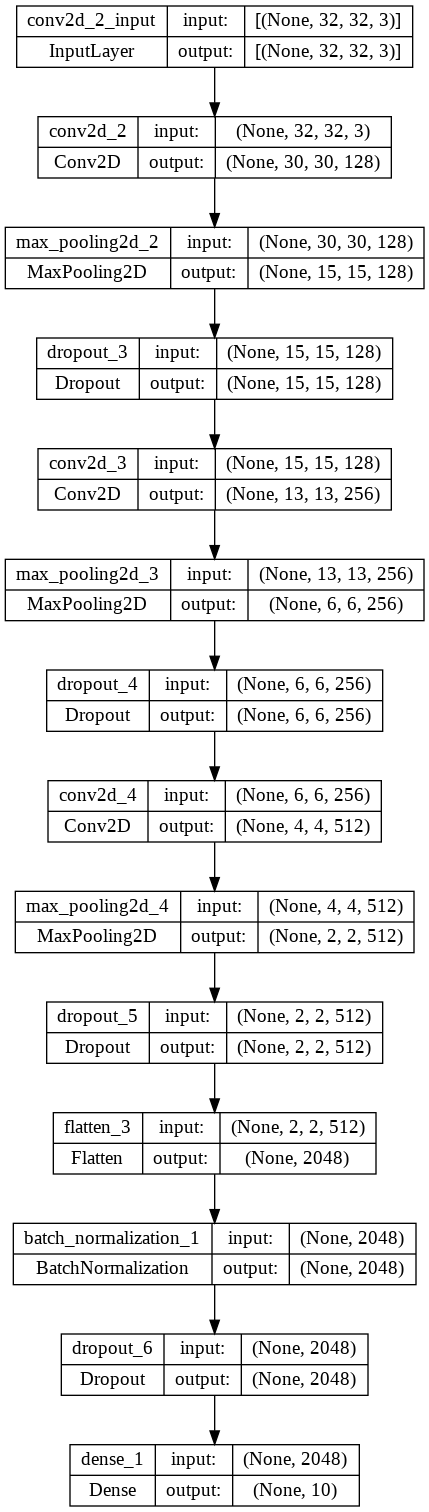

In [ ]:
keras.utils.plot_model(model4, "CIFAR10.png", show_shapes=True)

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start_time = dt.now()
history = model4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model4.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model4 fit time: {end_time-start_time}')

Epoch 1/200
704/704 [==============================] - 11s 13ms/step - loss: 1.6198 - accuracy: 0.4222 - val_loss: 1.3150 - val_accuracy: 0.5202
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.2651 - accuracy: 0.5521 - val_loss: 1.0912 - val_accuracy: 0.6072
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1535 - accuracy: 0.5958 - val_loss: 1.0761 - val_accuracy: 0.6154
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 1.0862 - accuracy: 0.6205 - val_loss: 1.1057 - val_accuracy: 0.6158
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 1.0305 - accuracy: 0.6397 - val_loss: 0.9592 - val_accuracy: 0.6630
Epoch 6/200
704/704 [==============================] - 9s 13ms/step - loss: 0.9895 - accuracy: 0.6547 - val_loss: 0.9078 - val_accuracy: 0.6816
Epoch 7/200
704/704 [==============================] - 9s 13ms/step - loss: 0.9561 - accuracy: 0.6682 - val_loss: 0.8496 - val_accuracy

### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model4 = tf.keras.models.load_model("CNN_model4.h5")
print(f"Test acc: {model4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.6703 - accuracy: 0.7726
Test acc: 0.773


### Predictions

In [ ]:
preds = model4.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 4ms/step
shape of preds:  (10000, 10)


### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
14  0.795     0.723     0.699         0.760
15  0.773     0.732     0.655         0.780
16  0.758     0.735     0.745         0.742
17  0.752     0.739     0.710         0.759
18  0.744     0.739     0.730         0.742

### Plot Training Metrics (Loss and Accuracy)

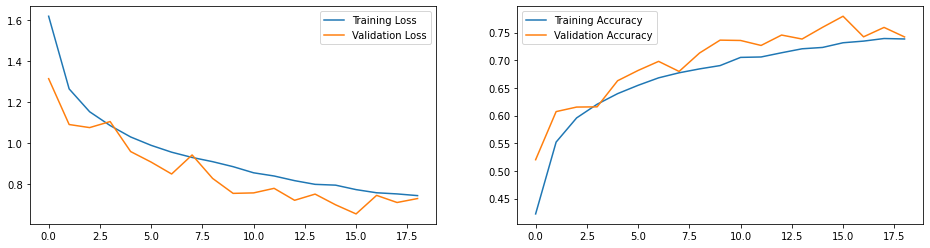

In [ ]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model4.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.86      0.79      1000
           1       0.93      0.87      0.90      1000
           2       0.80      0.54      0.65      1000
           3       0.57      0.65      0.61      1000
           4       0.76      0.70      0.73      1000
           5       0.69      0.69      0.69      1000
           6       0.80      0.82      0.81      1000
           7       0.77      0.86      0.81      1000
           8       0.86      0.88      0.87      1000
           9       0.86      0.85      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Accuracy Score: 0.7726
Root Mean Square Error: 1.9380402472601026


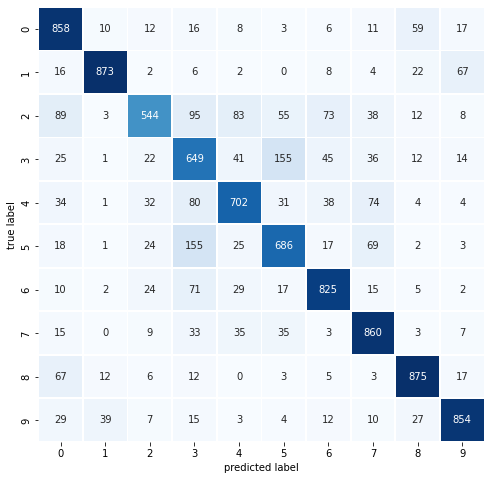

In [ ]:
plot_confusion_matrix(y_test,pred1)

### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('CNN_model4.h5')

In [ ]:
preds = model4.predict(x_test_norm)

313/313 [==============================] - 1s 3ms/step


In [ ]:
preds.shape

(10000, 10)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

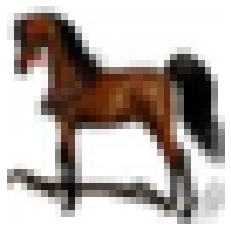

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model4.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model4.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 112ms/step


8

In [ ]:
layer_names = []
for layer in model4.layers:
    layer_names.append(layer.name)

layer_names

['conv2d_2',
 'max_pooling2d_2',
 'dropout_3',
 'conv2d_3',
 'max_pooling2d_3',
 'dropout_4',
 'conv2d_4',
 'max_pooling2d_4',
 'dropout_5',
 'flatten_3',
 'batch_normalization_1',
 'dropout_6',
 'dense_1']

In [ ]:
# Crashes

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model4.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model4.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model4.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 3ms/step




```
# This is formatted as code
```

### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.006s...
[t-SNE] Computed neighbors for 3250 samples in 1.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.728654
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.489456
[t-SNE] KL divergence after 300 iterations: 2.763352


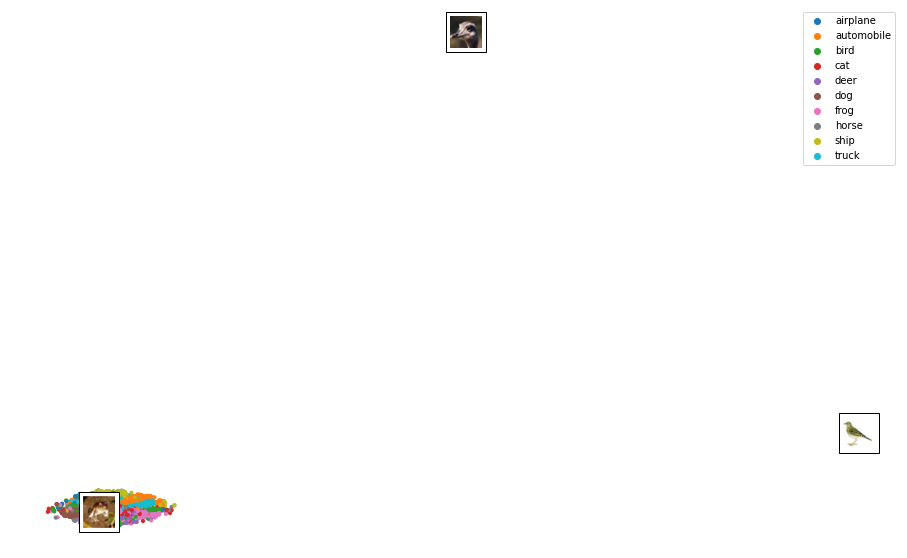

In [ ]:
# Plotting the T-SNE
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 5: You will conduct several more experiments. (a) Redo all the 4 experiments with some regularization technique. (b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

### Model 5 - DNN with 2 layers with regularization

In [ ]:
model5 = models.Sequential()
model5.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
# 1st layer
model5.add(layers.Dense(name='layer1',units = 256, activation = tf.nn.relu))
# 2nd layer
model5.add(layers.Dense(name='layer2',units = 512, activation = tf.nn.relu))
# output layer ## With Regularization
model5.add(layers.Dense(name='OuputLayer',units = 10, activation = tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001))) # 10 input layers for 10 classes


In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 layer1 (Dense)              (None, 256)               786688    
                                                                 
 layer2 (Dense)              (None, 512)               131584    
                                                                 
 OuputLayer (Dense)          (None, 10)                5130      
                                                                 
Total params: 923,402
Trainable params: 923,402
Non-trainable params: 0
_________________________________________________________________


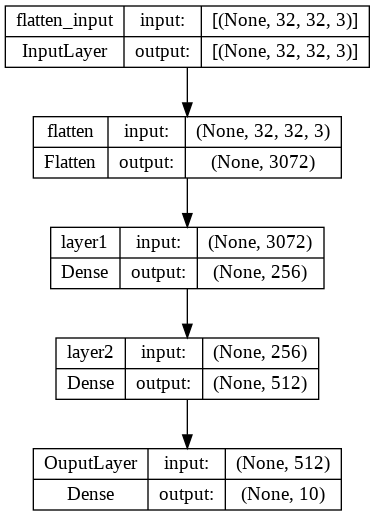

In [ ]:
keras.utils.plot_model(model5, "CIFAR10.png", show_shapes=True)

#### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
# fitting model5

start_time = dt.now()
history = model5.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model5.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model5 fit time: {end_time-start_time}')

Epoch 1/200
88/88 [==============================] - 4s 10ms/step - loss: 2.0080 - accuracy: 0.2787 - val_loss: 1.8142 - val_accuracy: 0.3594
Epoch 2/200
88/88 [==============================] - 1s 7ms/step - loss: 1.7481 - accuracy: 0.3828 - val_loss: 1.7231 - val_accuracy: 0.3794
Epoch 3/200
88/88 [==============================] - 1s 7ms/step - loss: 1.6639 - accuracy: 0.4134 - val_loss: 1.7097 - val_accuracy: 0.3812
Epoch 4/200
88/88 [==============================] - 1s 7ms/step - loss: 1.6136 - accuracy: 0.4348 - val_loss: 1.6245 - val_accuracy: 0.4282
Epoch 5/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5568 - accuracy: 0.4556 - val_loss: 1.5886 - val_accuracy: 0.4332
Epoch 6/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5296 - accuracy: 0.4624 - val_loss: 1.5643 - val_accuracy: 0.4428
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4827 - accuracy: 0.4815 - val_loss: 1.5178 - val_accuracy: 0.4636
Epoch 8/200


#### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model5 = tf.keras.models.load_model("DNN_model5.h5")
print(f"Test acc: {model5.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.3962 - accuracy: 0.5173
Test acc: 0.517


#### Predictions

In [ ]:
preds = model5.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


#### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
15  1.313     0.542     1.442         0.494
16  1.302     0.548     1.417         0.504
17  1.288     0.552     1.428         0.498
18  1.271     0.561     1.434         0.496
19  1.260     0.566     1.441         0.495

#### Plot Training Metrics (Loss and Accuracy)

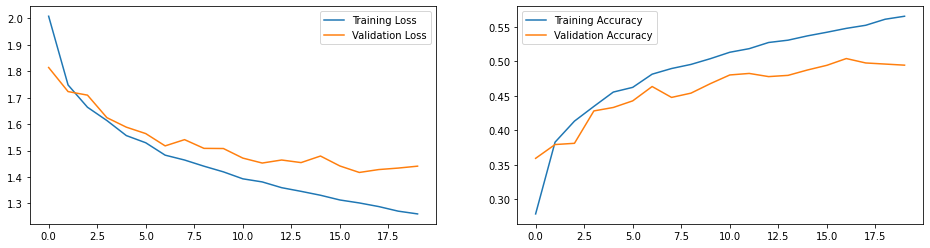

In [ ]:
plot_history(history)

#### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model5.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.60      0.55      0.58      1000
           1       0.67      0.59      0.63      1000
           2       0.40      0.42      0.41      1000
           3       0.35      0.38      0.36      1000
           4       0.45      0.41      0.43      1000
           5       0.48      0.35      0.40      1000
           6       0.54      0.61      0.57      1000
           7       0.53      0.62      0.57      1000
           8       0.64      0.63      0.63      1000
           9       0.54      0.62      0.58      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000

Accuracy Score: 0.5173
Root Mean Square Error: 3.0176149522429134


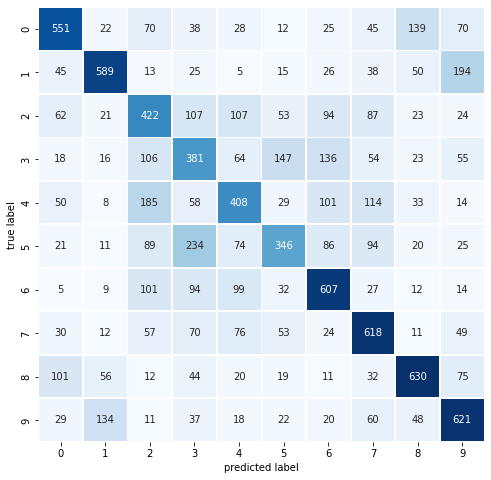

In [ ]:
plot_confusion_matrix(y_test,pred1)

#### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model5 = tf.keras.models.load_model('DNN_model5.h5')

In [ ]:
preds = model5.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


In [ ]:
preds.shape

(10000, 10)

#### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

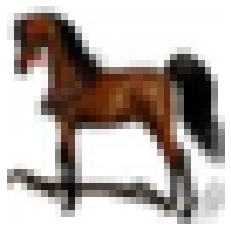

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model5.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model5.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 66ms/step


4

In [ ]:
layer_names = []
for layer in model5.layers:
    layer_names.append(layer.name)

layer_names

['flatten', 'layer1', 'layer2', 'OuputLayer']

In [ ]:
# Might crash runtime

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model5.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model5.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model5.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 2ms/step




```
# This is formatted as code
```

#### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...
[t-SNE] Computed neighbors for 3250 samples in 0.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.271020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.824211
[t-SNE] KL divergence after 300 iterations: 2.478370


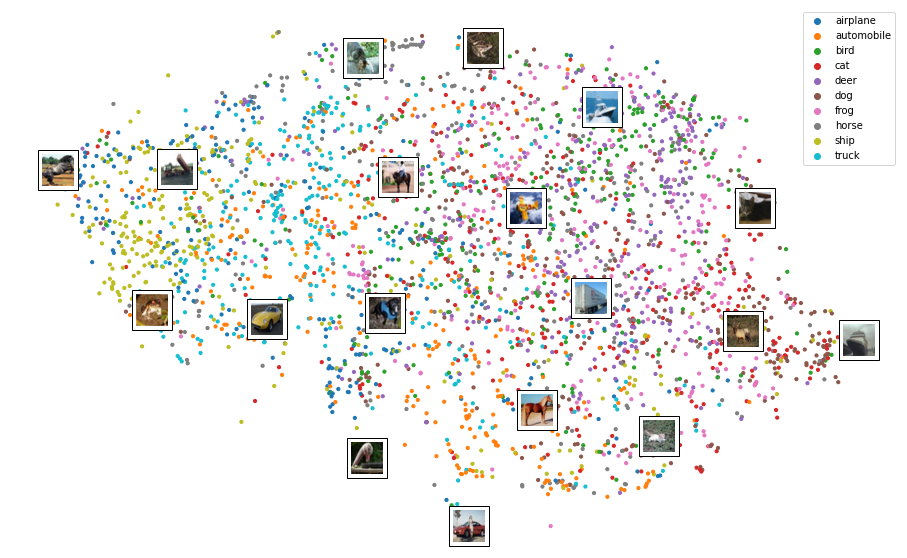

In [ ]:
# Plotting T-SNE
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Model 6 - DNN with 3 layers with regularization

In [ ]:
model6 = models.Sequential()
model6.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
# 1st layer
model6.add(layers.Dense(name='layer1',units = 256, activation = tf.nn.relu))
# 2nd layer
model6.add(layers.Dense(name='layer2',units = 512, activation = tf.nn.relu))
# 3rd layer
model6.add(layers.Dense(name='layer3',units = 512, activation = tf.nn.relu))
# output layer ## With Regularization
model6.add(layers.Dense(name='OuputLayer',units = 10, activation = tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001))) # 10 input layers for 10 classes



In [ ]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 layer1 (Dense)              (None, 256)               786688    
                                                                 
 layer2 (Dense)              (None, 512)               131584    
                                                                 
 layer3 (Dense)              (None, 512)               262656    
                                                                 
 OuputLayer (Dense)          (None, 10)                5130      
                                                                 
Total params: 1,186,058
Trainable params: 1,186,058
Non-trainable params: 0
_________________________________________________________________


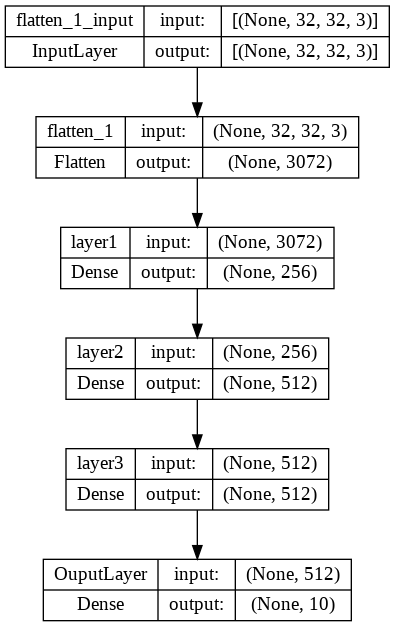

In [ ]:
keras.utils.plot_model(model6, "CIFAR10.png", show_shapes=True)

#### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
# Training model6

start_time = dt.now()
history = model6.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model6.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model6 fit time: {end_time-start_time}')

Epoch 1/200
88/88 [==============================] - 1s 10ms/step - loss: 1.9576 - accuracy: 0.2958 - val_loss: 1.7920 - val_accuracy: 0.3566
Epoch 2/200
88/88 [==============================] - 1s 8ms/step - loss: 1.7282 - accuracy: 0.3814 - val_loss: 1.6835 - val_accuracy: 0.3974
Epoch 3/200
88/88 [==============================] - 1s 8ms/step - loss: 1.6278 - accuracy: 0.4219 - val_loss: 1.6174 - val_accuracy: 0.4234
Epoch 4/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5616 - accuracy: 0.4470 - val_loss: 1.6318 - val_accuracy: 0.4256
Epoch 5/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5101 - accuracy: 0.4642 - val_loss: 1.5580 - val_accuracy: 0.4494
Epoch 6/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4643 - accuracy: 0.4848 - val_loss: 1.5286 - val_accuracy: 0.4528
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4386 - accuracy: 0.4936 - val_loss: 1.5305 - val_accuracy: 0.4520
Epoch 8/200


#### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model6 = tf.keras.models.load_model("DNN_model6.h5")
print(f"Test acc: {model6.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.3708 - accuracy: 0.5235
Test acc: 0.524


#### Predictions

In [ ]:
preds = model6.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


#### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
21  1.033     0.642     1.460         0.509
22  1.023     0.644     1.433         0.519
23  0.982     0.660     1.450         0.507
24  0.969     0.664     1.456         0.512
25  0.943     0.675     1.472         0.502

#### Plot Training Metrics (Loss and Accuracy)

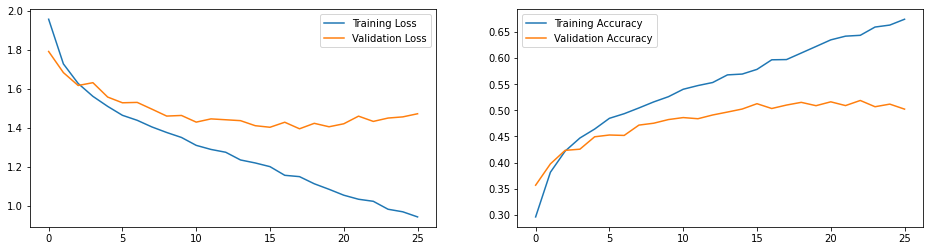

In [ ]:
plot_history(history)

#### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model6.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.57      0.62      0.59      1000
           1       0.65      0.65      0.65      1000
           2       0.39      0.46      0.42      1000
           3       0.38      0.31      0.34      1000
           4       0.45      0.43      0.44      1000
           5       0.47      0.35      0.40      1000
           6       0.56      0.57      0.57      1000
           7       0.53      0.66      0.59      1000
           8       0.63      0.61      0.62      1000
           9       0.58      0.58      0.58      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000

Accuracy Score: 0.5235
Root Mean Square Error: 3.013751814599205


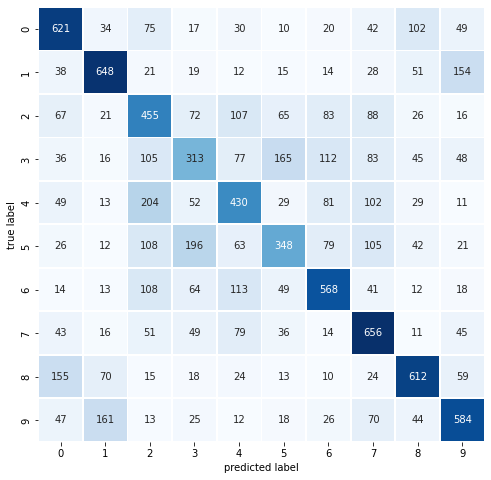

In [ ]:
plot_confusion_matrix(y_test,pred1)

#### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model6 = tf.keras.models.load_model('DNN_model6.h5')

In [ ]:
preds = model6.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


In [ ]:
preds.shape

(10000, 10)

#### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

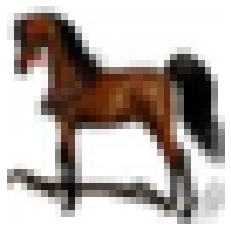

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model6.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model6.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 55ms/step


5

In [ ]:
layer_names = []
for layer in model6.layers:
    layer_names.append(layer.name)

layer_names

['flatten_1', 'layer1', 'layer2', 'layer3', 'OuputLayer']

In [ ]:
# Might crash runtime

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model6.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model6.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model6.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 3ms/step




```
# This is formatted as code
```

#### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.012s...
[t-SNE] Computed neighbors for 3250 samples in 0.977s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 2.737199
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.811012
[t-SNE] KL divergence after 300 iterations: 2.499594


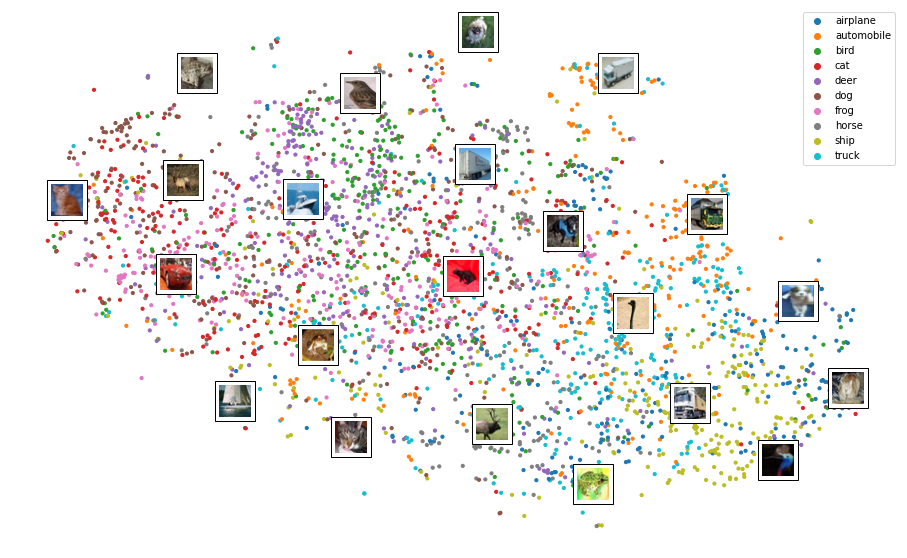

In [ ]:
# Plotting T-SNE
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Model 7 - CNN with 2 convolution/max pooling layers with regularization

In [ ]:
model7 = Sequential([
  # layer 1
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  # layer 2
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), #  using regularization
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)        

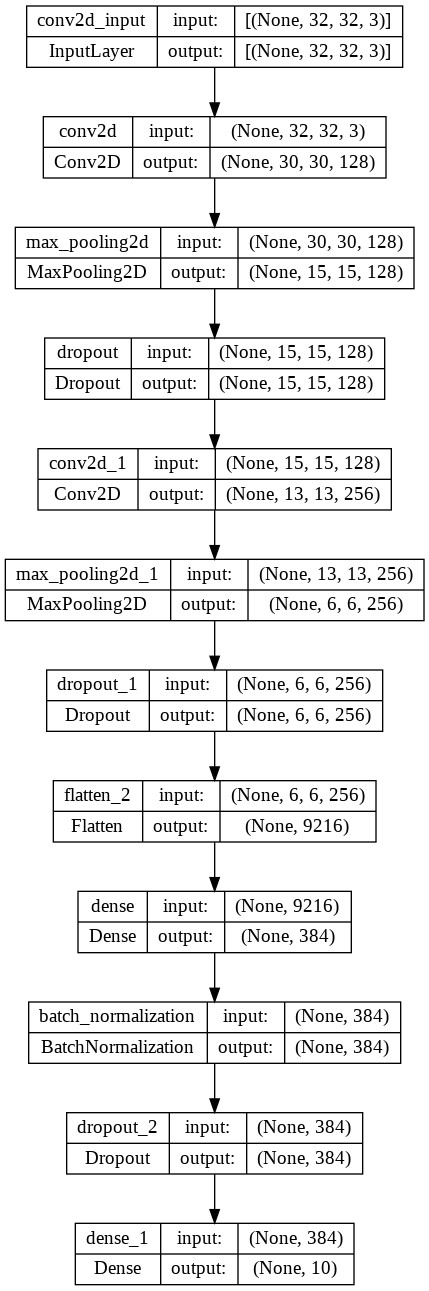

In [ ]:
keras.utils.plot_model(model7, "CIFAR10.png", show_shapes=True)

#### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
# training model7
start_time = dt.now()
history = model7.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model7.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model7 fit time: {end_time-start_time}')

Epoch 1/200
704/704 [==============================] - 16s 14ms/step - loss: 1.6820 - accuracy: 0.4482 - val_loss: 1.4937 - val_accuracy: 0.5380
Epoch 2/200
704/704 [==============================] - 8s 12ms/step - loss: 1.4166 - accuracy: 0.5705 - val_loss: 1.3810 - val_accuracy: 0.5662
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 1.3237 - accuracy: 0.6169 - val_loss: 1.3130 - val_accuracy: 0.6124
Epoch 4/200
704/704 [==============================] - 8s 12ms/step - loss: 1.2719 - accuracy: 0.6402 - val_loss: 1.2116 - val_accuracy: 0.6528
Epoch 5/200
704/704 [==============================] - 8s 12ms/step - loss: 1.2239 - accuracy: 0.6618 - val_loss: 1.1858 - val_accuracy: 0.6688
Epoch 6/200
704/704 [==============================] - 8s 11ms/step - loss: 1.1828 - accuracy: 0.6801 - val_loss: 1.1254 - val_accuracy: 0.7006
Epoch 7/200
704/704 [==============================] - 8s 11ms/step - loss: 1.1557 - accuracy: 0.6912 - val_loss: 1.1818 - val_accuracy

#### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model7 = tf.keras.models.load_model("CNN_model7.h5")
print(f"Test acc: {model7.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.1469 - accuracy: 0.6950
Test acc: 0.695


#### Predictions

In [ ]:
preds = model7.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


#### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
4  1.224     0.662     1.186         0.669
5  1.183     0.680     1.125         0.701
6  1.156     0.691     1.182         0.680
7  1.132     0.703     1.283         0.642
8  1.118     0.709     1.137         0.691

#### Plot Training Metrics (Loss and Accuracy)

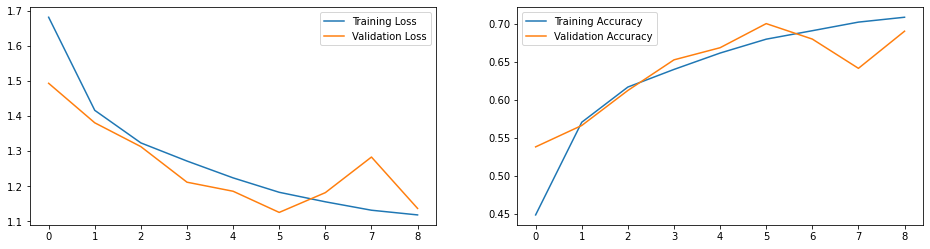

In [ ]:
plot_history(history)

#### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model7.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.82      0.73      1000
           1       0.88      0.78      0.83      1000
           2       0.53      0.66      0.59      1000
           3       0.53      0.53      0.53      1000
           4       0.55      0.73      0.63      1000
           5       0.76      0.47      0.58      1000
           6       0.87      0.64      0.74      1000
           7       0.79      0.73      0.76      1000
           8       0.81      0.80      0.81      1000
           9       0.77      0.79      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.71      0.69      0.70     10000
weighted avg       0.71      0.69      0.70     10000

Accuracy Score: 0.695
Root Mean Square Error: 2.309783539641756


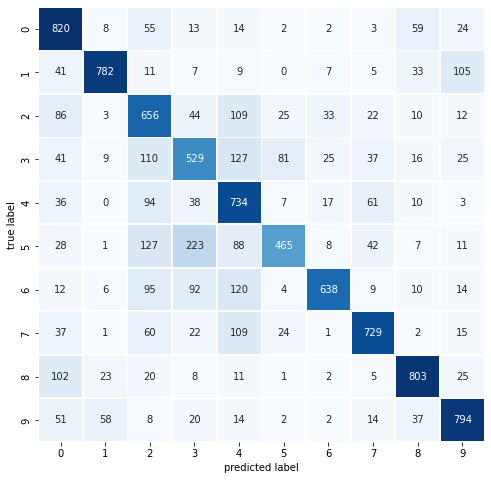

In [ ]:
plot_confusion_matrix(y_test,pred1)

#### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model7 = tf.keras.models.load_model('CNN_model7.h5')

In [ ]:
preds = model7.predict(x_test_norm)

313/313 [==============================] - 1s 3ms/step


In [ ]:
preds.shape

(10000, 10)

#### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

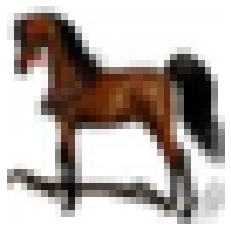

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model7.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model7.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 86ms/step


8

In [ ]:
layer_names = []
for layer in model7.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'flatten_2',
 'dense',
 'batch_normalization',
 'dropout_2',
 'dense_1']

In [ ]:
# Might crash runtine

# These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model7.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
4  1.224     0.662     1.186         0.669
5  1.183     0.680     1.125         0.701
6  1.156     0.691     1.182         0.680
7  1.132     0.703     1.283         0.642
8  1.118     0.709     1.137         0.691

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model7.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model7.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 3ms/step




```
# This is formatted as code
```

#### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...
[t-SNE] Computed neighbors for 3250 samples in 0.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 1.315874
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.093948
[t-SNE] KL divergence after 300 iterations: 1.919364


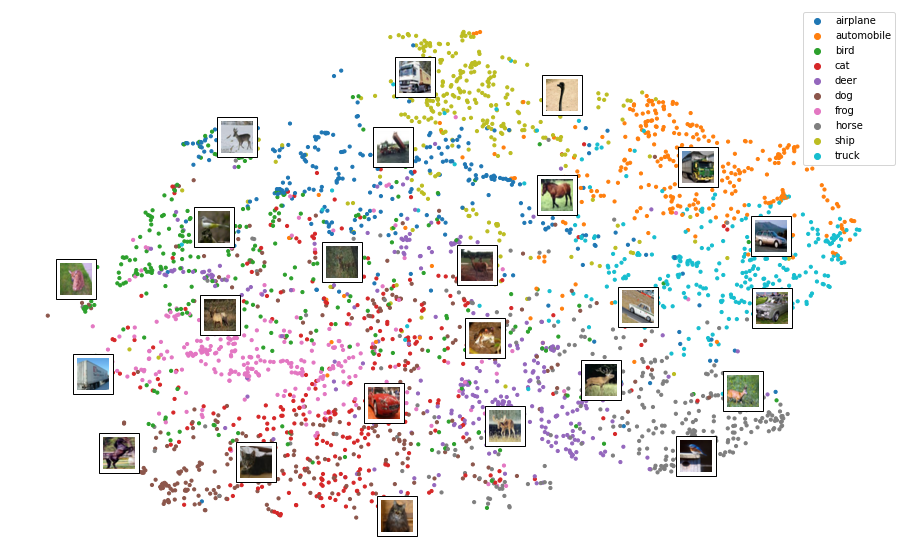

In [ ]:

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Model 8 - CNN with 3 convolution/max pooling layers with regularization

In [ ]:
model8 = Sequential([
  # layer 1
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  # layer 2
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  # layer 3
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), #  using regularization
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 6, 6, 256)        

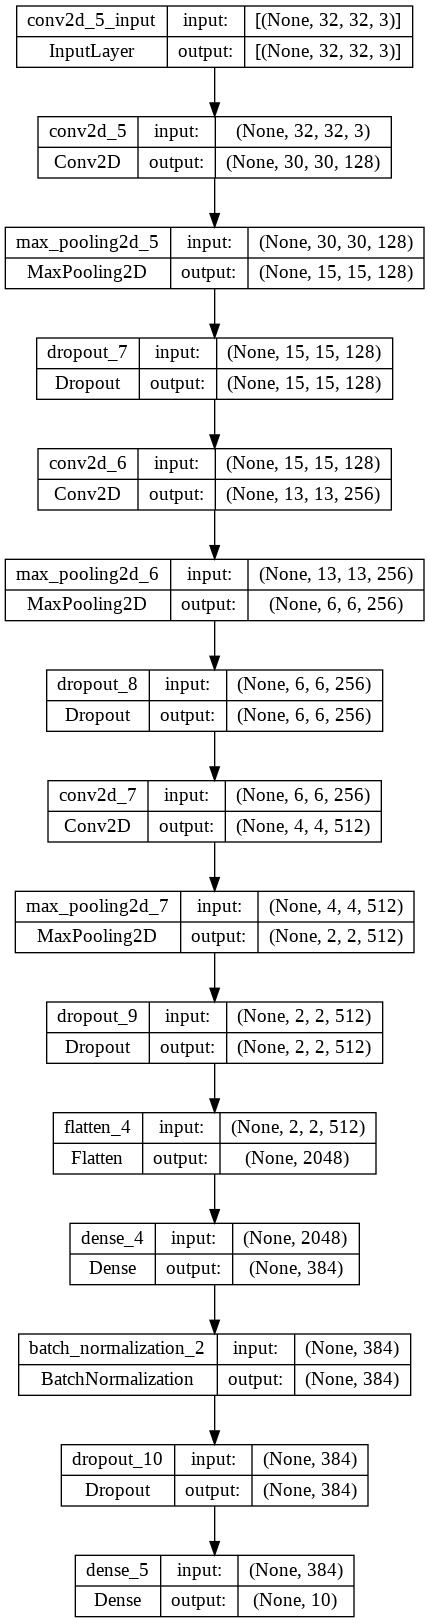

In [ ]:
keras.utils.plot_model(model8, "CIFAR10.png", show_shapes=True)

#### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
# training model8
start_time = dt.now()
history = model8.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model8.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model8 fit time: {end_time-start_time}')

Epoch 1/200
704/704 [==============================] - 13s 16ms/step - loss: 1.6834 - accuracy: 0.4155 - val_loss: 1.3970 - val_accuracy: 0.5284
Epoch 2/200
704/704 [==============================] - 11s 16ms/step - loss: 1.3261 - accuracy: 0.5556 - val_loss: 1.2069 - val_accuracy: 0.5996
Epoch 3/200
704/704 [==============================] - 12s 17ms/step - loss: 1.1889 - accuracy: 0.6158 - val_loss: 1.3291 - val_accuracy: 0.5706
Epoch 4/200
704/704 [==============================] - 10s 14ms/step - loss: 1.0870 - accuracy: 0.6555 - val_loss: 1.0068 - val_accuracy: 0.6896
Epoch 5/200
704/704 [==============================] - 12s 18ms/step - loss: 1.0207 - accuracy: 0.6834 - val_loss: 0.9524 - val_accuracy: 0.7002
Epoch 6/200
704/704 [==============================] - 11s 16ms/step - loss: 0.9653 - accuracy: 0.7027 - val_loss: 0.8784 - val_accuracy: 0.7392
Epoch 7/200
704/704 [==============================] - 11s 15ms/step - loss: 0.9170 - accuracy: 0.7189 - val_loss: 0.8337 - val_ac

#### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model8 = tf.keras.models.load_model("CNN_model8.h5")
print(f"Test acc: {model8.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.7804 - accuracy: 0.7700
Test acc: 0.770


#### Predictions

In [ ]:
preds = model8.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


**bold text**## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
9   0.825     0.755     0.777         0.767
10  0.801     0.760     0.768         0.774
11  0.784     0.767     0.785         0.765
12  0.762     0.774     0.759         0.771
13  0.743     0.780     0.791         0.769

#### Plot Training Metrics (Loss and Accuracy)

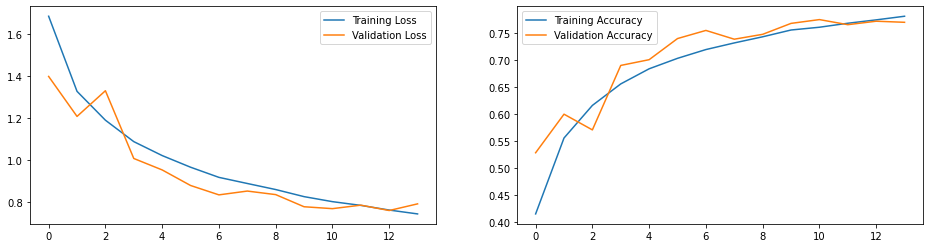

In [ ]:
plot_history(history)

#### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model8.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 3ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1000
           1       0.94      0.85      0.89      1000
           2       0.72      0.64      0.68      1000
           3       0.72      0.46      0.56      1000
           4       0.71      0.74      0.73      1000
           5       0.67      0.73      0.70      1000
           6       0.76      0.88      0.81      1000
           7       0.77      0.83      0.80      1000
           8       0.79      0.91      0.85      1000
           9       0.78      0.91      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Accuracy Score: 0.77
Root Mean Square Error: 1.9988996973335105


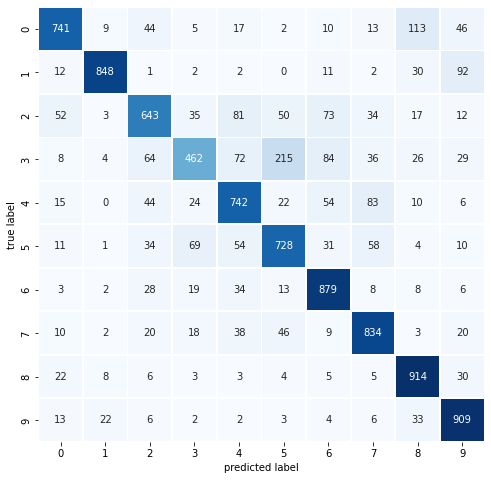

In [ ]:
plot_confusion_matrix(y_test,pred1)

#### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model8 = tf.keras.models.load_model('CNN_model8.h5')

In [ ]:
preds = model8.predict(x_test_norm)

313/313 [==============================] - 1s 3ms/step


In [ ]:
preds.shape

(10000, 10)

#### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

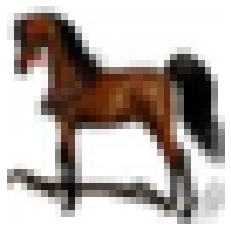

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model8.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model8.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 116ms/step


8

In [ ]:
layer_names = []
for layer in model8.layers:
    layer_names.append(layer.name)

layer_names

['conv2d_5',
 'max_pooling2d_5',
 'dropout_7',
 'conv2d_6',
 'max_pooling2d_6',
 'dropout_8',
 'conv2d_7',
 'max_pooling2d_7',
 'dropout_9',
 'flatten_4',
 'dense_4',
 'batch_normalization_2',
 'dropout_10',
 'dense_5']

In [ ]:
# crashes

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model8.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model8.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model8.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 3ms/step




```
# This is formatted as code
```

#### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.005s...
[t-SNE] Computed neighbors for 3250 samples in 0.474s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 1.158000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.479843
[t-SNE] KL divergence after 300 iterations: 1.721742


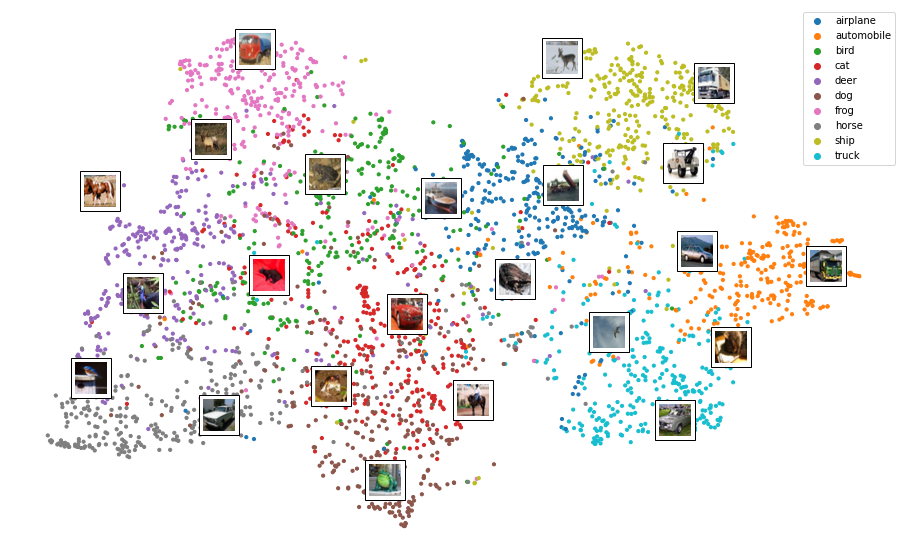

In [ ]:

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Model 9 - CNN with 2 convolution/max pooling layers with regularization and increased number of filters (512) in output layer. Also increased strides to 3

In [ ]:
model9 = Sequential([
  # layer 1
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((3, 3),strides=3),
  Dropout(0.3),
  # layer 2
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((3, 3),strides=3),
  Dropout(0.3),
  Flatten(),
  Dense(units=512,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), #  using regularization
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 10, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 256)         0

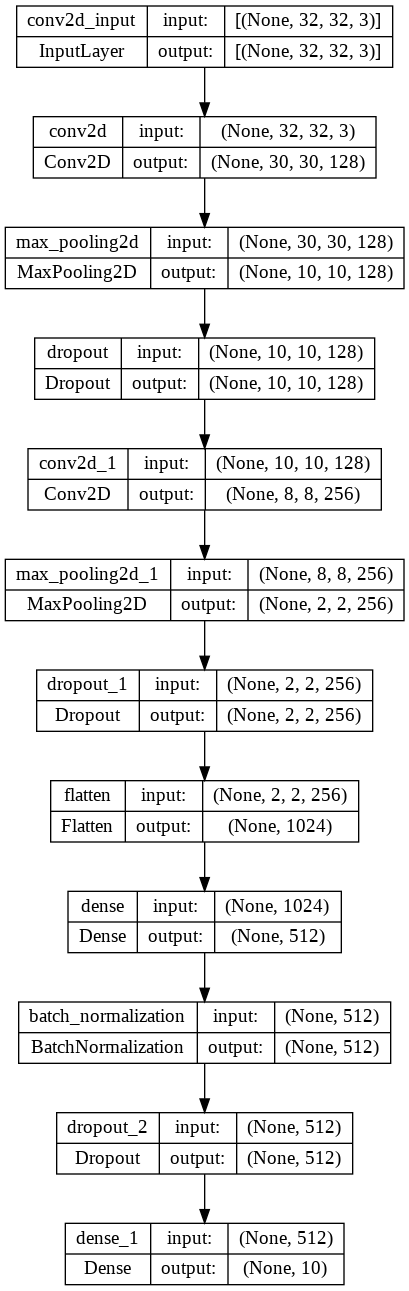

In [ ]:
keras.utils.plot_model(model9, "CIFAR10.png", show_shapes=True)

#### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start_time = dt.now()
history = model9.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model9.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model9 fit time: {end_time-start_time}')

Epoch 1/200
704/704 [==============================] - 14s 8ms/step - loss: 1.7857 - accuracy: 0.3660 - val_loss: 1.5651 - val_accuracy: 0.4576
Epoch 2/200
704/704 [==============================] - 6s 8ms/step - loss: 1.4848 - accuracy: 0.4926 - val_loss: 1.4553 - val_accuracy: 0.5244
Epoch 3/200
704/704 [==============================] - 5s 7ms/step - loss: 1.3773 - accuracy: 0.5426 - val_loss: 1.2829 - val_accuracy: 0.5754
Epoch 4/200
704/704 [==============================] - 5s 7ms/step - loss: 1.3077 - accuracy: 0.5723 - val_loss: 1.2453 - val_accuracy: 0.5872
Epoch 5/200
704/704 [==============================] - 5s 8ms/step - loss: 1.2638 - accuracy: 0.5872 - val_loss: 1.2058 - val_accuracy: 0.6220
Epoch 6/200
704/704 [==============================] - 6s 8ms/step - loss: 1.2183 - accuracy: 0.6051 - val_loss: 1.1023 - val_accuracy: 0.6404
Epoch 7/200
704/704 [==============================] - 5s 7ms/step - loss: 1.1790 - accuracy: 0.6203 - val_loss: 1.1851 - val_accuracy: 0.612

#### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model9 = tf.keras.models.load_model("CNN_model9.h5")
print(f"Test acc: {model9.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.9141 - accuracy: 0.7218
Test acc: 0.722


#### Predictions

In [ ]:
preds = model9.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


#### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  1.009     0.683     0.950         0.704
17  1.001     0.683     0.904         0.717
18  0.988     0.690     0.910         0.715
19  0.986     0.690     0.962         0.692
20  0.973     0.697     0.927         0.704

#### Plot Training Metrics (Loss and Accuracy)

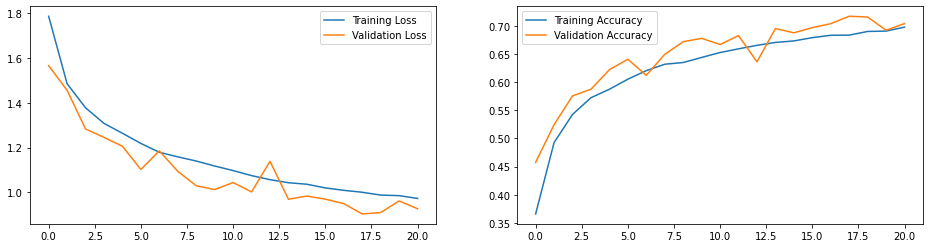

In [ ]:
plot_history(history)

#### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model9.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.71      0.73      1000
           1       0.79      0.87      0.83      1000
           2       0.75      0.55      0.63      1000
           3       0.59      0.51      0.55      1000
           4       0.62      0.76      0.68      1000
           5       0.67      0.64      0.66      1000
           6       0.72      0.84      0.77      1000
           7       0.80      0.71      0.75      1000
           8       0.73      0.85      0.78      1000
           9       0.82      0.77      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

Accuracy Score: 0.7218
Root Mean Square Error: 2.2190087877248255


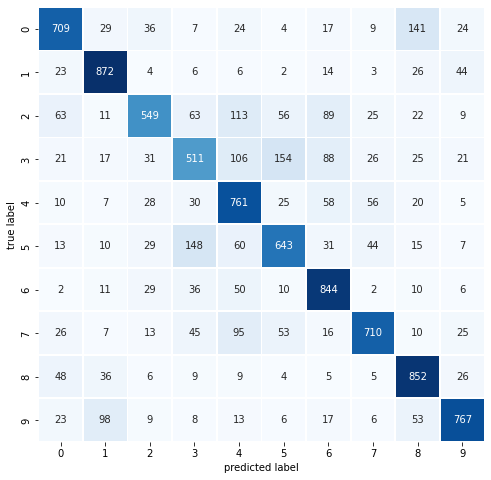

In [ ]:
plot_confusion_matrix(y_test,pred1)

#### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model9 = tf.keras.models.load_model('CNN_model9.h5')

In [ ]:
preds = model9.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


In [ ]:
preds.shape

(10000, 10)

#### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

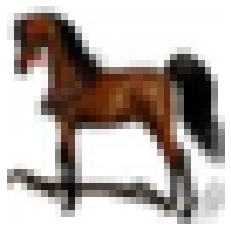

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model9.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model9.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 106ms/step


8

In [ ]:
layer_names = []
for layer in model9.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_2',
 'dense_1']

In [ ]:
# Might crash runtime

# # These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model9.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model9.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model9.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 0s 3ms/step


In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
16  1.009     0.683     0.950         0.704
17  1.001     0.683     0.904         0.717
18  0.988     0.690     0.910         0.715
19  0.986     0.690     0.962         0.692
20  0.973     0.697     0.927         0.704

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model9.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model9.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 1s 5ms/step




```
# This is formatted as code
```

#### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.939s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 0.929121
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.965179
[t-SNE] KL divergence after 300 iterations: 1.933751


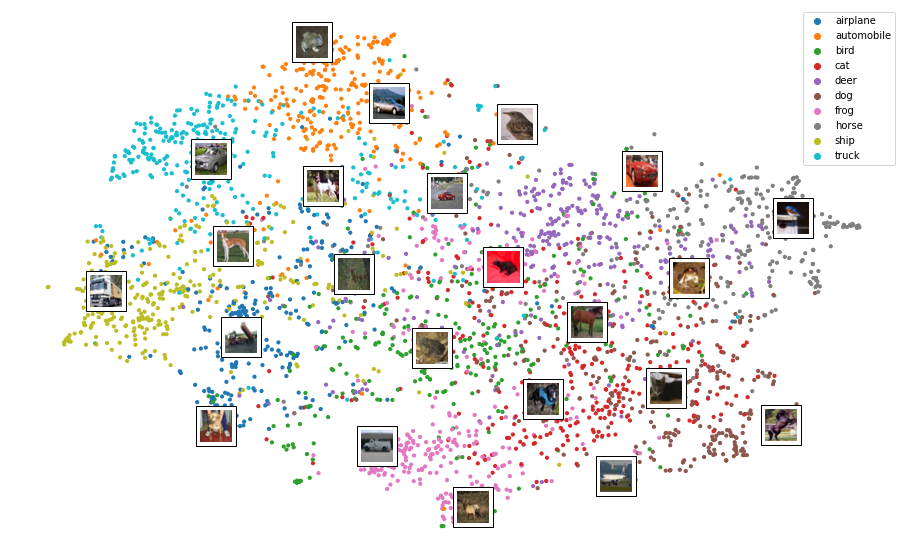

In [ ]:

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Model 10 - CNN with 3 convolution/max pooling layers with regularization and increased number of filters (512) in output layer.
And with lower dropout rates

In [ ]:
model10 = Sequential([
  # layer 1
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.2),
  # layer 2
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.2),
  # layer 3
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((1, 1),strides=2),
  Dropout(0.2),
  Flatten(),
  Dense(units=512,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

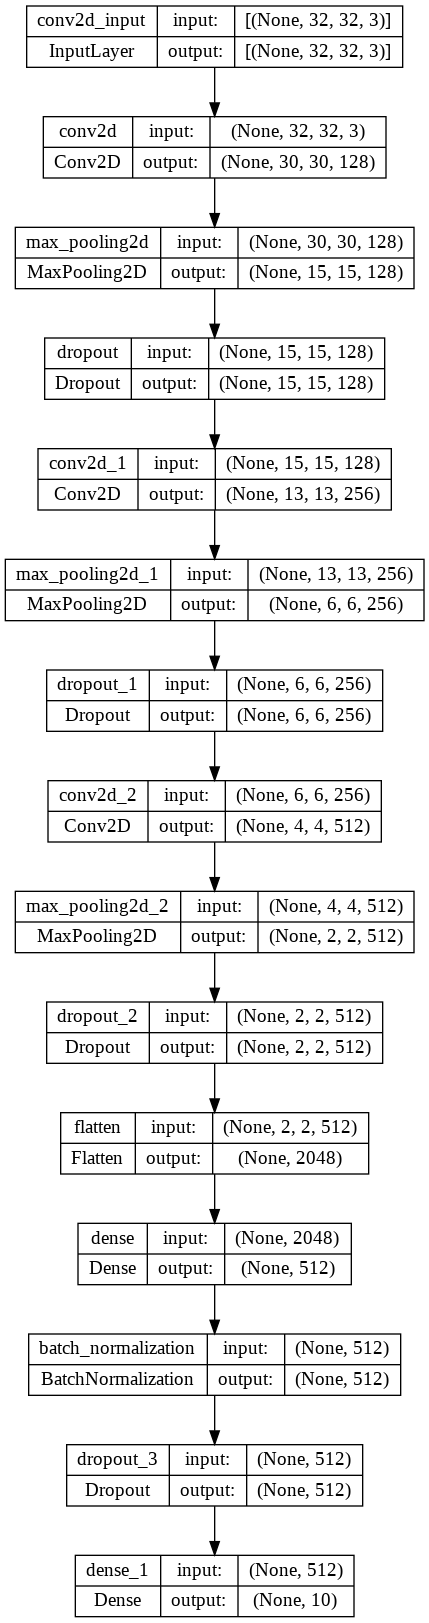

In [ ]:
keras.utils.plot_model(model10, "CIFAR10.png", show_shapes=True)

#### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start_time = dt.now()
history = model10.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model10.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time = dt.now()
print(f'Model10 fit time: {end_time-start_time}')

Epoch 1/200
704/704 [==============================] - 19s 14ms/step - loss: 1.6957 - accuracy: 0.4033 - val_loss: 1.5391 - val_accuracy: 0.4664
Epoch 2/200
704/704 [==============================] - 9s 13ms/step - loss: 1.3425 - accuracy: 0.5433 - val_loss: 1.3853 - val_accuracy: 0.5262
Epoch 3/200
704/704 [==============================] - 9s 13ms/step - loss: 1.2083 - accuracy: 0.6013 - val_loss: 1.1128 - val_accuracy: 0.6304
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 1.1175 - accuracy: 0.6373 - val_loss: 1.0599 - val_accuracy: 0.6496
Epoch 5/200
704/704 [==============================] - 10s 14ms/step - loss: 1.0431 - accuracy: 0.6646 - val_loss: 0.9952 - val_accuracy: 0.6778
Epoch 6/200
704/704 [==============================] - 9s 13ms/step - loss: 0.9811 - accuracy: 0.6896 - val_loss: 0.9777 - val_accuracy: 0.6784
Epoch 7/200
704/704 [==============================] - 9s 13ms/step - loss: 0.9310 - accuracy: 0.7094 - val_loss: 0.9474 - val_accurac

#### Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model10 = tf.keras.models.load_model("CNN_model10.h5")
print(f"Test acc: {model10.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 3s 7ms/step - loss: 0.9129 - accuracy: 0.7141
Test acc: 0.714


#### Predictions

In [ ]:
preds = model10.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 2s 5ms/step
shape of preds:  (10000, 10)


#### Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
8   0.839     0.739     0.942         0.700
9   0.812     0.750     0.895         0.722
10  0.777     0.763     0.932         0.710
11  0.748     0.773     0.919         0.716
12  0.712     0.786     0.943         0.713

#### Plot Training Metrics (Loss and Accuracy)

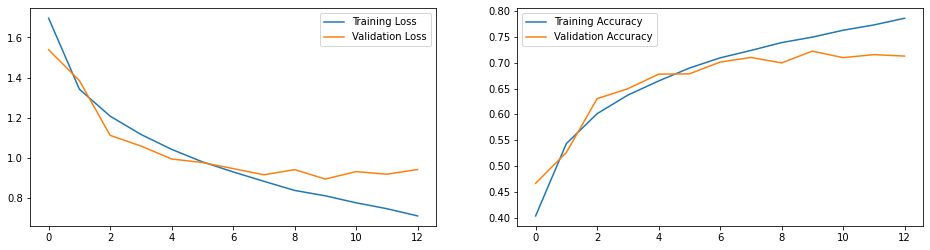

In [ ]:
plot_history(history)

#### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model10.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 4ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1000
           1       0.81      0.85      0.83      1000
           2       0.68      0.51      0.58      1000
           3       0.53      0.58      0.56      1000
           4       0.63      0.68      0.66      1000
           5       0.67      0.60      0.64      1000
           6       0.74      0.82      0.78      1000
           7       0.74      0.76      0.75      1000
           8       0.74      0.87      0.80      1000
           9       0.84      0.77      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

Accuracy Score: 0.7141
Root Mean Square Error: 2.2141815643709077


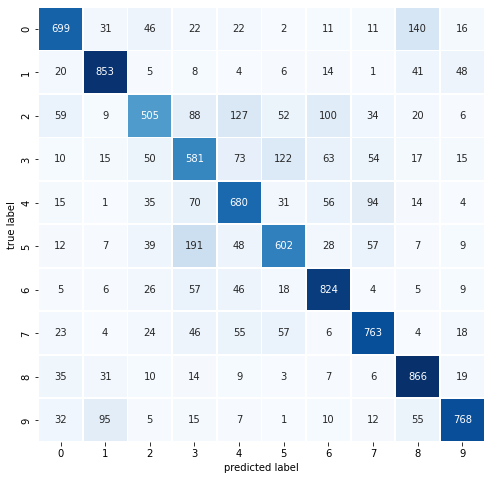

In [ ]:
plot_confusion_matrix(y_test,pred1)

#### Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model10 = tf.keras.models.load_model('CNN_model10.h5')

In [ ]:
preds = model10.predict(x_test_norm)

313/313 [==============================] - 1s 3ms/step


In [ ]:
preds.shape

(10000, 10)

#### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

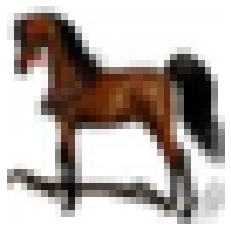

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model10.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model10.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 154ms/step


8

In [ ]:
layer_names = []
for layer in model10.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1']

In [ ]:
# Might crash kernal

# These are the names of the layers, so can have them as part of our plot
# layer_names = []
# for layer in model10.layers[:3]:
#     layer_names.append(layer.name)

# images_per_row = 16

# # Now let's display our feature maps
# for layer_name, layer_activation in zip(layer_names, activations):
#     # This is the number of features in the feature map
#     n_features = layer_activation.shape[-1]

#     # The feature map has shape (1, size, size, n_features)
#     size = layer_activation.shape[1]

#     # We will tile the activation channels in this matrix
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((size * n_cols, images_per_row * size))

#     # We'll tile each filter into this big horizontal grid
#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             # Post-process the feature to make it visually palatable
#             channel_image -= channel_image.mean()
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size,
#                          row * size : (row + 1) * size] = channel_image

#     # Display the grid
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

# plt.show();

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
8   0.839     0.739     0.942         0.700
9   0.812     0.750     0.895         0.722
10  0.777     0.763     0.932         0.710
11  0.748     0.773     0.919         0.716
12  0.712     0.786     0.943         0.713

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model10.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model10.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

102/102 [==============================] - 1s 5ms/step




```
# This is formatted as code
```

#### sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 1.262594
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.895828
[t-SNE] KL divergence after 300 iterations: 1.795100


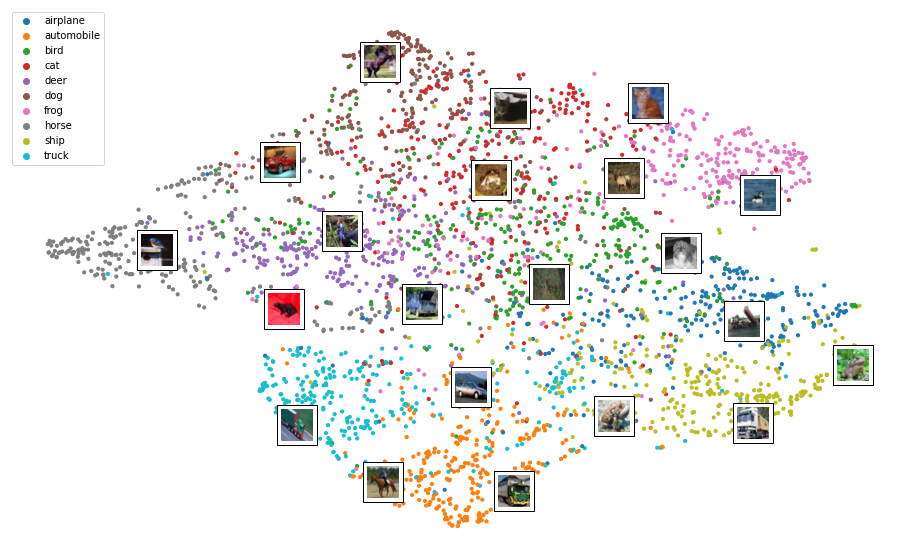

In [ ]:

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

THE END